# 타이타닉 생존 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# data import
titanic = sns.load_dataset('titanic')[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']]
display(titanic.head())
display(titanic.info())

,pclass,sex,age,sibsp,parch,fare,survived
0,3,male,22.0,1,0,7.2500,0
1,1,female,38.0,1,0,71.2833,1
2,3,female,26.0,0,0,7.9250,1
3,1,female,35.0,1,0,53.1000,1
4,3,male,35.0,0,0,8.0500,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    891 non-null    int64  
 1   sex       891 non-null    object 
 2   age       714 non-null    float64
 3   sibsp     891 non-null    int64  
 4   parch     891 non-null    int64  
 5   fare      891 non-null    float64
 6   survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


None

In [2]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(titanic[['sex']])
encoded_titanic = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['sex']))

# 원본 데이터와 합치기
titanic_encoded = pd.concat([titanic.drop(columns=['sex']), encoded_titanic], axis=1)
titanic_encoded.head()

,pclass,age,sibsp,parch,fare,survived,sex_female,sex_male
0,3,22.0,1,0,7.2500,0,0.0,1.0
1,1,38.0,1,0,71.2833,1,1.0,0.0
2,3,26.0,0,0,7.9250,1,1.0,0.0
3,1,35.0,1,0,53.1000,1,1.0,0.0
4,3,35.0,0,0,8.0500,0,0.0,1.0


In [3]:
# 결측치 처리
idx = titanic_encoded['age'].isna()

X_full = titanic_encoded[['survived', 'pclass', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male']][~idx].to_numpy()
X_empty = titanic_encoded[['survived', 'pclass', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male']][idx].to_numpy()
y_full = titanic_encoded['age'][~idx].to_numpy()
y_empty = titanic_encoded['age'][idx].to_numpy()

from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

n_neighbors = range(1, 50, 2)
knr_scores = []

for k in n_neighbors:
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train, y_train)
    knr_train = knr.score(X_train, y_train)
    knr_test = knr.score(X_test, y_test)
    knr_scores.append((k, knr_test, knr_train))

max_k, max_knr_test, max_knr_train = max(knr_scores, key=lambda x:x[1])

print(f'=== KNN Regressor(best k={max_k}) ===')
print('Train score:', max_knr_train)
print('Test score :', max_knr_test)

knr = KNeighborsRegressor(n_neighbors=max_k)
knr.fit(X_train, y_train)
pass

=== KNN Regressor(best k=37) ===
Train score: 0.3013929715609671
Test score : 0.22752243439766862


In [4]:
titanic_noempty = titanic_encoded.copy()
titanic_noempty['age'][idx] = knr.predict(X_empty)

In [5]:
def detect_outliers_by_group(data: pd.DataFrame, group_col: str, value_col: str):
    """그룹별 이상치 탐지"""
    # 우선 전원 모두 이상치 아님(False)
    outliers = pd.Series(False, data.index)
    # 현재 group_col 기준 유니크한 데이터 (pclass -> 1, 2, 3)
    for group in data[group_col].unique():
        # df[df['pclass'] == 3]['fare'] /  df[df['pclass'] == 1]['fare'] / 
        group_data = data[data[group_col] == group][value_col]
        Q1 = group_data.quantile(0.25)        
        Q3 = group_data.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        group_outliers = (group_data < lower) | (group_data > upper)
        outliers[group_data.index] = group_outliers

    return outliers

titanic_clean = titanic_noempty.copy()

fare_outliers_by_pclass = detect_outliers_by_group(titanic_noempty, 'pclass', 'fare')

for pclass in titanic['pclass'].unique():
    class_data = titanic[titanic['pclass'] == pclass]
    class_median = class_data['fare'].median()
    
    # 해당 등급의 이상치를 중앙값으로 대체
    class_outliers = fare_outliers_by_pclass & (titanic['pclass'] == pclass)
    titanic_clean.loc[class_outliers, 'fare'] = class_median

## Decision Tree Classifier

In [6]:
titanic_clean.head()

,pclass,age,sibsp,parch,fare,survived,sex_female,sex_male
0,3,22.0,1,0,7.2500,0,0.0,1.0
1,1,38.0,1,0,71.2833,1,1.0,0.0
2,3,26.0,0,0,7.9250,1,1.0,0.0
3,1,35.0,1,0,53.1000,1,1.0,0.0
4,3,35.0,0,0,8.0500,0,0.0,1.0


In [7]:
X = titanic_clean[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male']].to_numpy()
y = titanic_clean['survived'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:

n_neighbors = range(1, 50, 2)
knr_scores = []

for k in n_neighbors:
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train, y_train)
    knr_train = knr.score(X_train, y_train)
    knr_test = knr.score(X_test, y_test)
    knr_scores.append((k, knr_test, knr_train))

max_k, max_knr_test, max_knr_train = max(knr_scores, key=lambda x:x[1])

print(f'=== KNN Regressor(best k={max_k}) ===')
print('Train score:', max_knr_train)
print('Test score :', max_knr_test)


=== Decision Tree Classifier ===
Train score: 0.8592814371257484
Test score : 0.8161434977578476


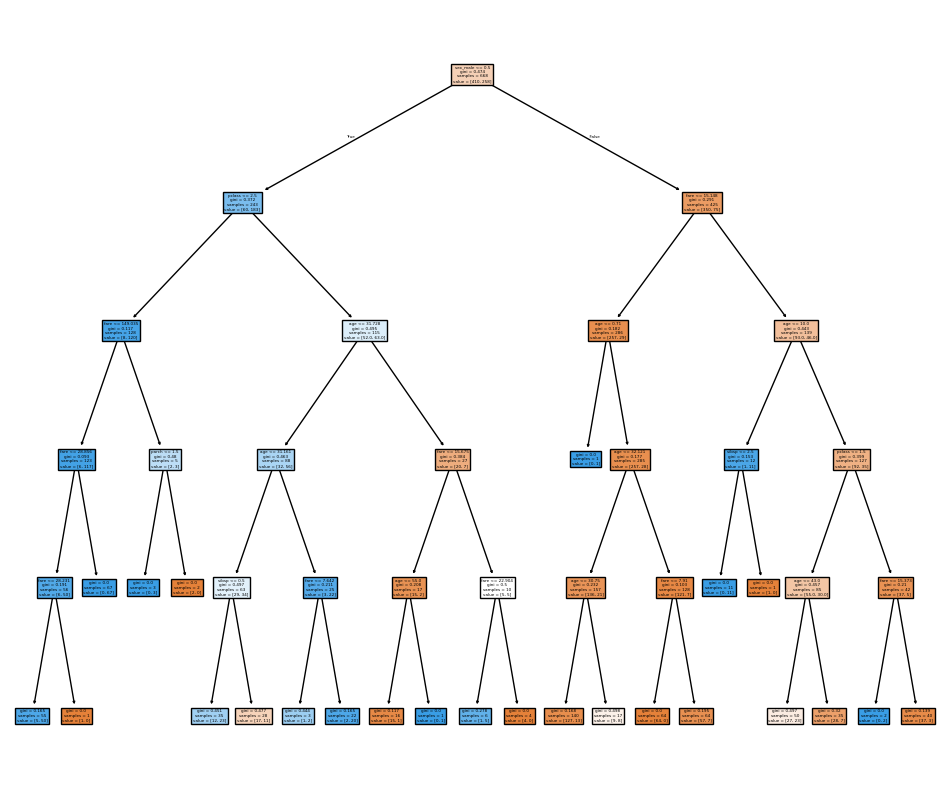

In [18]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# max_depths = range(1, 10)
# dtc_scores = []

# for max_depth in max_depths:
#     dtc = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
#     dtc.fit(X_train, y_train)
#     dtc_train = dtc.score(X_train, y_train)
#     dtc_test = dtc.score(X_test, y_test)
#     dtc_scores.append((max_depth, dtc_train, dtc_test))

# max_max_depth, max_dtc_test, max_dtc_train = max(dtc_scores, key=lambda x:x[1])
# print(f'=== Decision Tree Classifier(best max_depth={max_max_depth}) ===')
# print(f'Train score: {max_dtc_train}')
# print(f'Test score : {max_dtc_test}') 

# dtc = DecisionTreeClassifier(random_state=42, max_depth=max_max_depth)
# dtc.fit(X_train, y_train)

dtc = DecisionTreeClassifier(random_state=42, max_depth=5)
dtc.fit(X_train, y_train)
print(f'=== Decision Tree Classifier ===')
print(f'Train score: {dtc.score(X_train, y_train)}')
print(f'Test score : {dtc.score(X_test, y_test)}') 

plt.figure(figsize=(12,10))
plot_tree(dtc, filled=True, feature_names=['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male'])
plt.show()